# **Compare Time Series Prediction Models**

## **SARIMAX, Prophet**

## **Import libraries, packages and the dataset**

In [1]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 3.8 MB/s 
     |████████████████████████████████| 9.8 MB 35.9 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [37]:
import pmdarima as pm

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

import pandas as pd
import numpy as no
import datetime
import requests
import warnings

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates

from xgboost import XGBRegressor

from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from prophet import Prophet
from prophet.plot import plot_plotly, add_changepoints_to_plot

from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam

warnings.filterwarnings('ignore')


In [4]:
# Import and preview data

df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Time Series/Compare TS prediction models/time_series_covid19_deaths_global.csv')
df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,5/6/22,5/7/22,5/8/22,5/9/22,5/10/22,5/11/22,5/12/22,5/13/22,5/14/22,5/15/22
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,7684,7684,7684,7685,7685,7686,7686,7686,7687,7690
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,3496,3496,3497,3497,3497,3497,3497,3497,3497,3497
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,6875,6875,6875,6875,6875,6875,6875,6875,6875,6875
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,153,153,153,153,153,153,153,153,153,153
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,1900,1900,1900,1900,1900,1900,1900,1900,1900,1900


## **Time Series Preprocessing**

In [5]:
# See columns
df.columns

Index(['Province/State', 'Country/Region', 'Lat', 'Long', '1/22/20', '1/23/20',
       '1/24/20', '1/25/20', '1/26/20', '1/27/20',
       ...
       '5/6/22', '5/7/22', '5/8/22', '5/9/22', '5/10/22', '5/11/22', '5/12/22',
       '5/13/22', '5/14/22', '5/15/22'],
      dtype='object', length=849)

Take all the rows, but only the columns starting from 1/22/20 onwards.


In [6]:
d=df.loc[:,'1/22/20':]

Transpose the data frame.

In [7]:
d=d.transpose()

In [8]:
d.head()

,0,1,2,3,4,5,6,7,8,9,...,275,276,277,278,279,280,281,282,283,284
1/22/20,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1/23/20,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1/24/20,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1/25/20,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1/26/20,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Sum row-wise.

In [9]:
d=d.sum(axis=1)


In [10]:
d.head()

1/22/20    17
1/23/20    18
1/24/20    26
1/25/20    42
1/26/20    56
dtype: int64

We only need the numerical values, so we will convert d to a list.

In [11]:
d=d.to_list()

Create a new dataframe with 2 columns.

In [12]:
dataset=pd.DataFrame(columns=['ds','y'])

Get the dates from the columns in data dataframe, starting from the fifth column (in string format).

In [13]:
dates=list(df.columns[4:])

Convert the string dates into datetime format using the to_datetime() method.

In [14]:
dates=list(pd.to_datetime(dates))

Assign the dates and covid data to the columns in the new dataframe.

In [20]:
dataset['ds']=dates
dataset['y']=d

Set ds as index.

In [22]:
dataset=dataset.set_index('ds')

Plot the data.

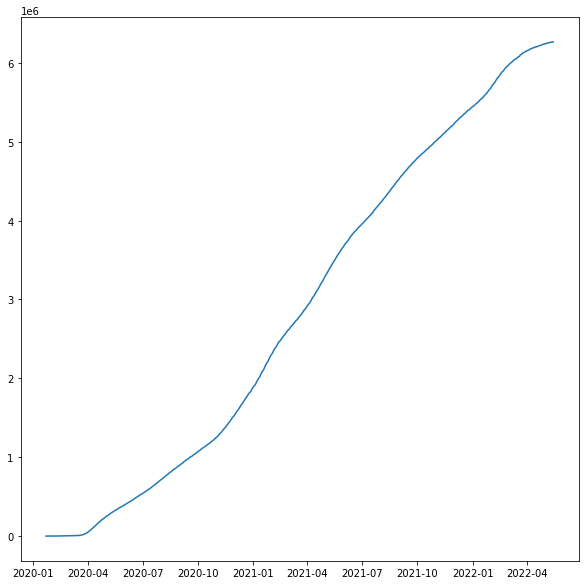

In [24]:
plt.figure(figsize=(10,10))
plt.plot(dataset)
plt.savefig('cumulative_daily_deaths',bbox_inches='tight', transparent=False)

Perform seasonal decomposition of the data using the seasonal_decompose() function from statsmodel. 

<Figure size 1440x1440 with 0 Axes>

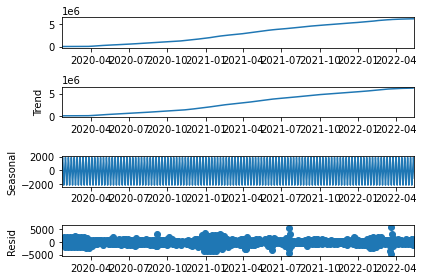

In [28]:
seas_d=sm.tsa.seasonal_decompose(dataset,model='add')
plt.figure(figsize=(20,20))
fig=seas_d.plot()
fig.set_figheight(4)

plt.show()

Transform the data to a stationary one by computing the difference between consecutive elements, using the diff() method. This takes every datapoint and substracts it from the previous value.

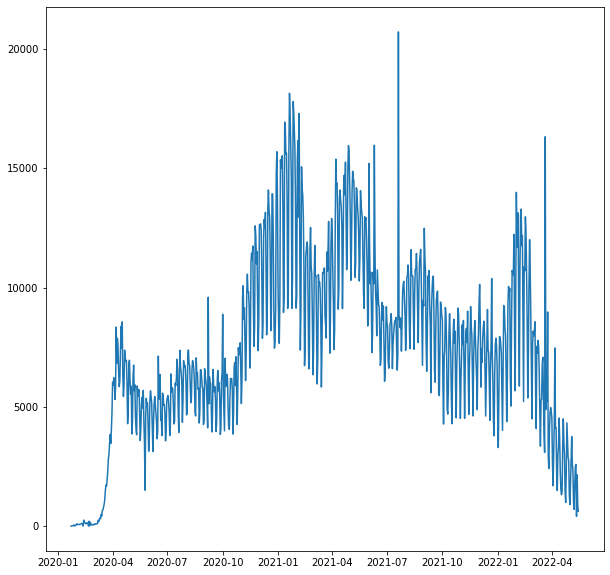

In [29]:
plt.figure(figsize=(10,10))
plt.plot(dataset.diff())
plt.savefig('daily_deaths_diff',bbox_inches='tight',transparent=False)

Zoom in:

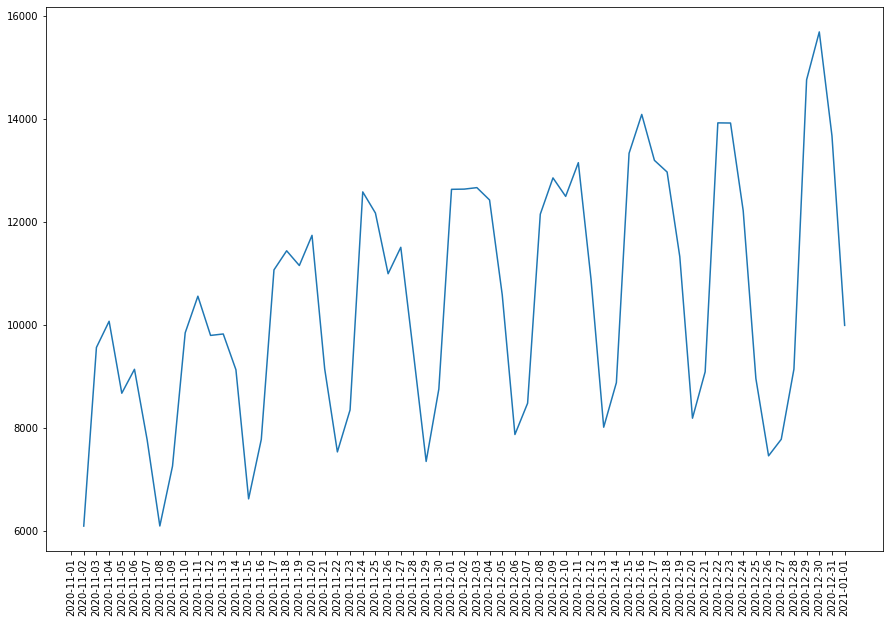

In [30]:
# Zoom in graph.

plt.figure(figsize=(15,10))
sample=dataset.loc['2020-11-01':'2021-01-01']
plt.plot(sample.diff())
plt.xticks(sample.index,rotation=90)
plt.savefig('daily_deaths_diff_sample', bbox_inches='tight', transparent=True)

Counting the days reveals a 7 day period of seasonality (weekly). Data is not yet stationary.

We apply the diff() method again -> Second order differencing -> the difference of the difference, or the change in the change.

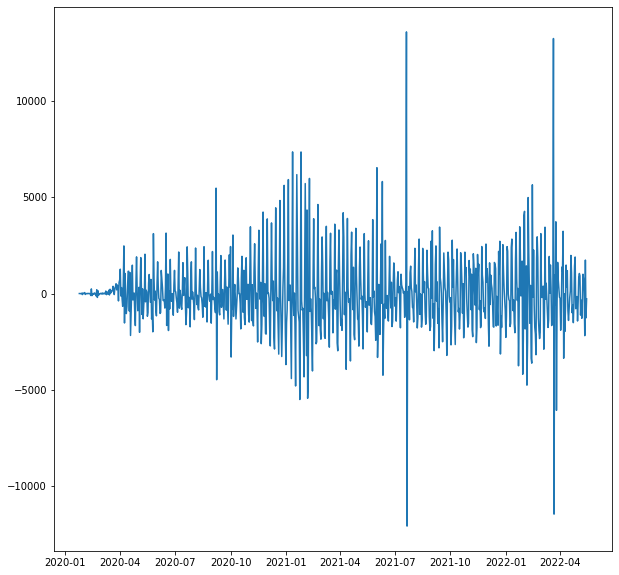

In [31]:
plt.figure(figsize=(10,10))
plt.plot(dataset.diff().diff())
plt.savefig('daily_deaths_2nd_order_diff',bbox_inches='tight', transparent=False)

Data is now stationary.

Create a new dataset with the Second order differencing.

In [32]:
dataset_diff=dataset.diff().diff()

Remove the first two data points, as they will be blank due to the second order differencing.

In [33]:
dataset_diff=dataset_diff.loc['2020-01-24':]

In time series analysis, the test set is close to the period we usually forecast in the given business use case. In this case, the standard prediction period is 1 month, so the test set will contain data after 15 Apr 22.

2022-04-15


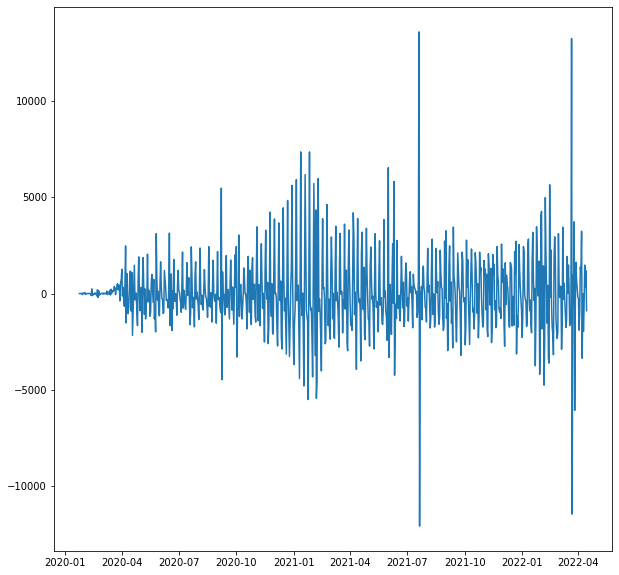

In [35]:
cutoff_date='2022-04-15'

print(cutoff_date)

train=dataset_diff.loc[dataset_diff.index < pd.to_datetime(cutoff_date)]
test=dataset_diff.loc[dataset_diff.index >= pd.to_datetime(cutoff_date)]

plt.figure(figsize=(10,10))
plt.plot(train)
plt.savefig('training_set', bbox_inches='tight', transparent=False)

## **Forecasting using SARIMAX (Seasonal AutoRegressive Integrated Moving Average with Exogenous Regressors)**

**SARIMAX uses 2 sets of parameters:**

- The order: a tuple of values p,q,d. They control the number of parameters in the model. In this model, we will use p=2, q=1, d=3.

- The seasonal_order: a tuple of values P, D, Q and s. They control the seasonal component of the model, and s is the periodicity of the dates. For example, weekly periodicity can be set with s=7.

p and seasonal P: indicate the number of AR terms (lags of the stationary series)

d and seasonal D: indicate differencing that must be done to stationary series

q and seasonal Q: indicate the number of MA terms (lags of the forecast errors)

lag: indicates the seasonal length in the data

Initialize the model.

In [39]:
model=SARIMAX(train, order=(2,1,3), seasonal_order=(0,0,0,7))

Call the fit method to optimize the model.

In [40]:
results=model.fit(disp=True)

Generate predictions using the model and compare them against the values in the test set.

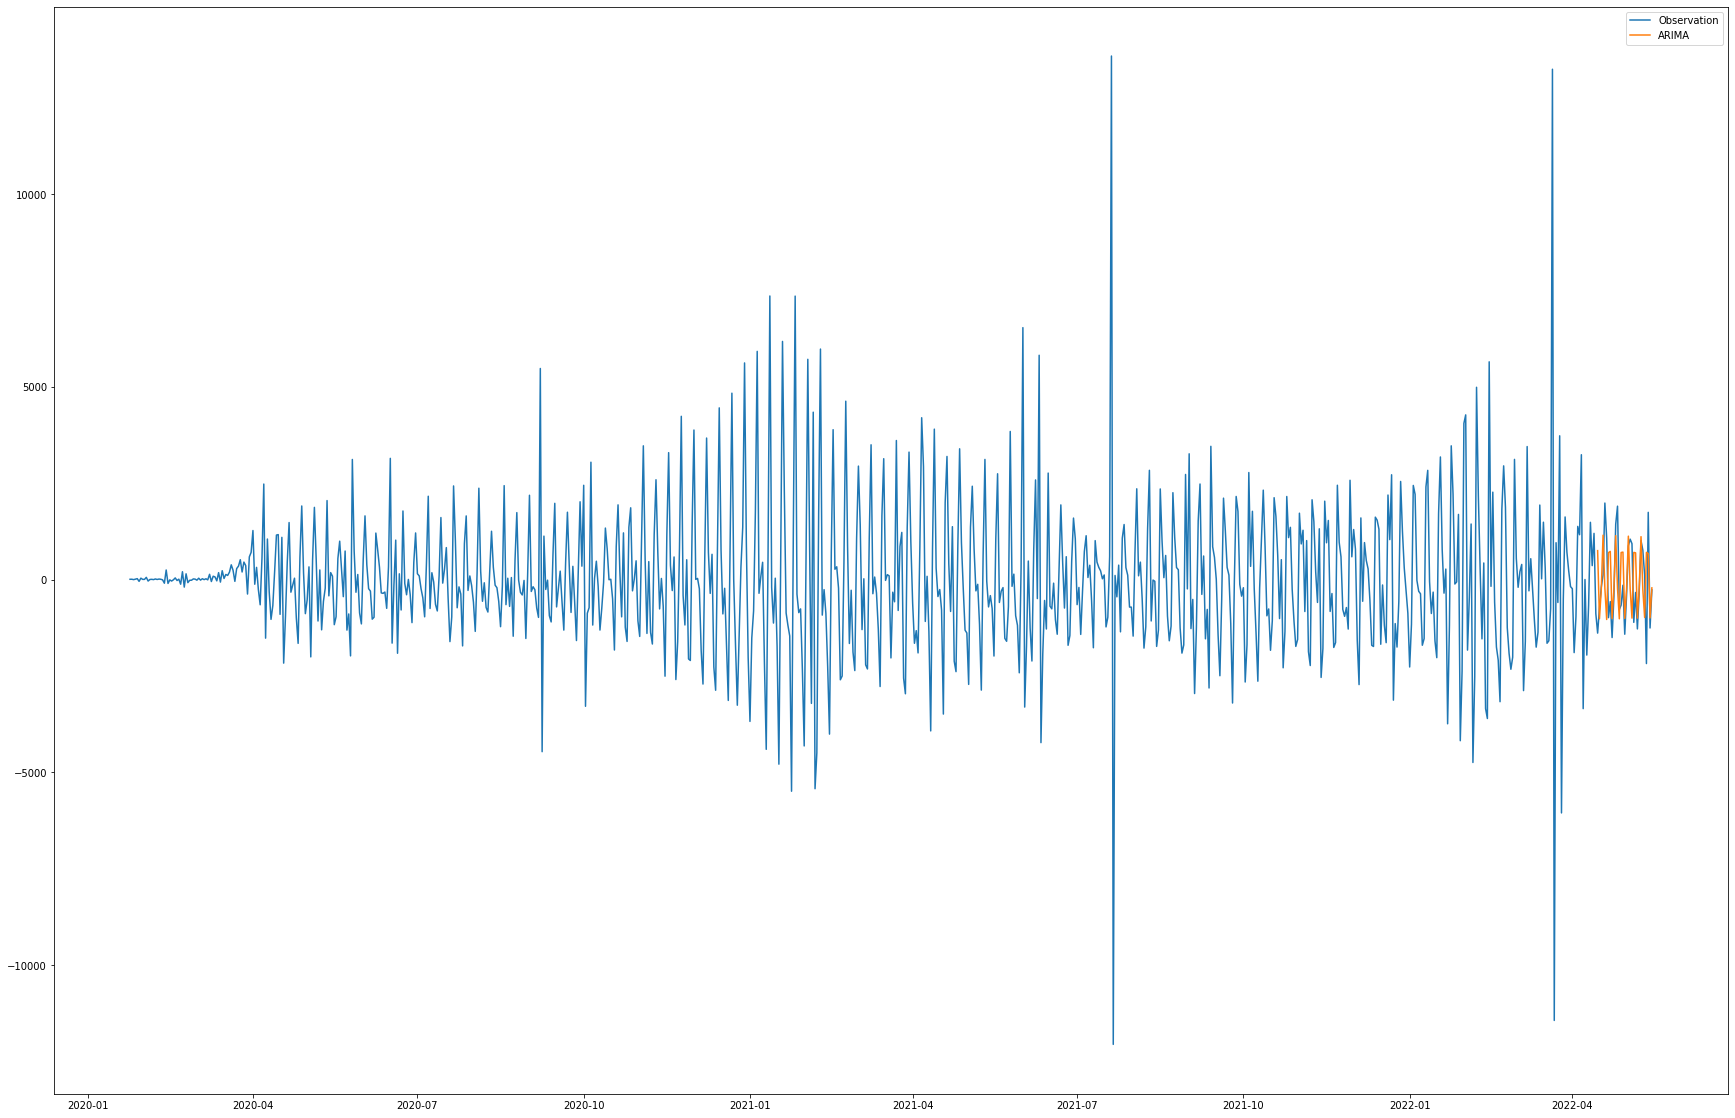

In [45]:
# Use the predict method on the test dataset.

sarimax_prediction=results.predict(start=cutoff_date,
                                   end='2022-05-15',
                                   dynamic=False)
plt.figure(figsize=(30,20))
l1, =plt.plot(dataset_diff, label='Observation')
l2, =plt.plot(sarimax_prediction, label='ARIMA')
plt.legend(handles=[l1,l2])
plt.savefig('SARIMAX_prediction', bbox_inches='tight', transparent=False)

To compare between different time series analysis approaches, we are going to use one of the validation measures: mean absolute error.

In [46]:
print('SARIMAX MAE=', mean_absolute_error(sarimax_prediction, test))

SARIMAX MAE= 973.1110890748267


We must find the best values of p, q, r that will minimize the error. We can use the auto_arima function from the pmdarima module to do that, in order to find the optimal parameter combination and return the best model.

In [47]:
model=pm.auto_arima(train,
                    start_p=1,
                    start_q=1,
                    m=7,
                    d=None,
                    seasonal=True,
                    start_P=0,
                    D=0,
                    trace=True,
                    error_action='ignore',
                    suppress_warnings=True,
                    stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[7] intercept   : AIC=14177.692, Time=3.49 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=14608.306, Time=0.05 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=14132.519, Time=1.87 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=14246.854, Time=2.55 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=14606.310, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=14609.181, Time=0.09 sec
 ARIMA(1,0,0)(2,0,0)[7] intercept   : AIC=14012.943, Time=6.77 sec
 ARIMA(1,0,0)(2,0,1)[7] intercept   : AIC=13938.046, Time=7.60 sec
 ARIMA(1,0,0)(1,0,1)[7] intercept   : AIC=13908.359, Time=4.67 sec
 ARIMA(1,0,0)(0,0,1)[7] intercept   : AIC=14380.746, Time=1.41 sec
 ARIMA(1,0,0)(1,0,2)[7] intercept   : AIC=13935.784, Time=7.96 sec
 ARIMA(1,0,0)(0,0,2)[7] intercept   : AIC=14270.143, Time=2.78 sec
 ARIMA(1,0,0)(2,0,2)[7] intercept   : AIC=inf, Time=7.28 sec
 ARIMA(0,0,0)(1,0,1)[7] intercept   : AIC=14032.703, Time=3.14 sec
 ARIMA(2,0,0)(1,0,1)[7] i

SARIMAX auto MAE= 1124.666272244373


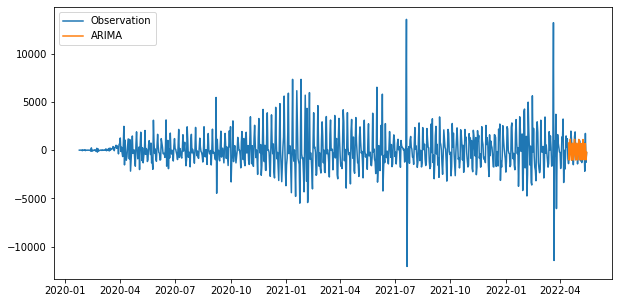

In [54]:
sarimax_prediction_automated=model.predict(n_periods=test.shape[0])
sarimax_prediction_automated=pd.DataFrame({'ds': test.index, 'y':sarimax_prediction_automated})
sarimax_prediction_automated.set_index('ds', inplace=True)
plt.figure(figsize=(10,5))
l1, =plt.plot(dataset_diff, label='Observation')
l2, =plt.plot(sarimax_prediction, label='ARIMA')
plt.legend(handles=[l1,l2])
plt.savefig('SARIMAX_prediction_automated', bbox_inches='tight', transparent=False)
print('SARIMAX auto MAE=', mean_absolute_error(sarimax_prediction_automated,test ))

Standard diagnostics plots enable the analysis of the model accuracy and whether there is any (residual) information in the data that should be used to improve the model.

The diagnostics package generates 4 diagnostics plots:

1. Standardized residuals over time plot: It calculated the residue, or the difference between observed and predicted values, as a function of time.

2. Histogram: The count of values against the computed residual.

3. Normal Q-Q: Generally, model errors should be normally distributed. This plot checks if this is the case. If the points are nearly linear, the errors are normally distributed.

4. Correlogram: The plot checks the autocorrelation in the data, to ensure that the data is random (necessary condition for the validity of the model). If the values are close to 0, this is an indication of the randomness of the data.

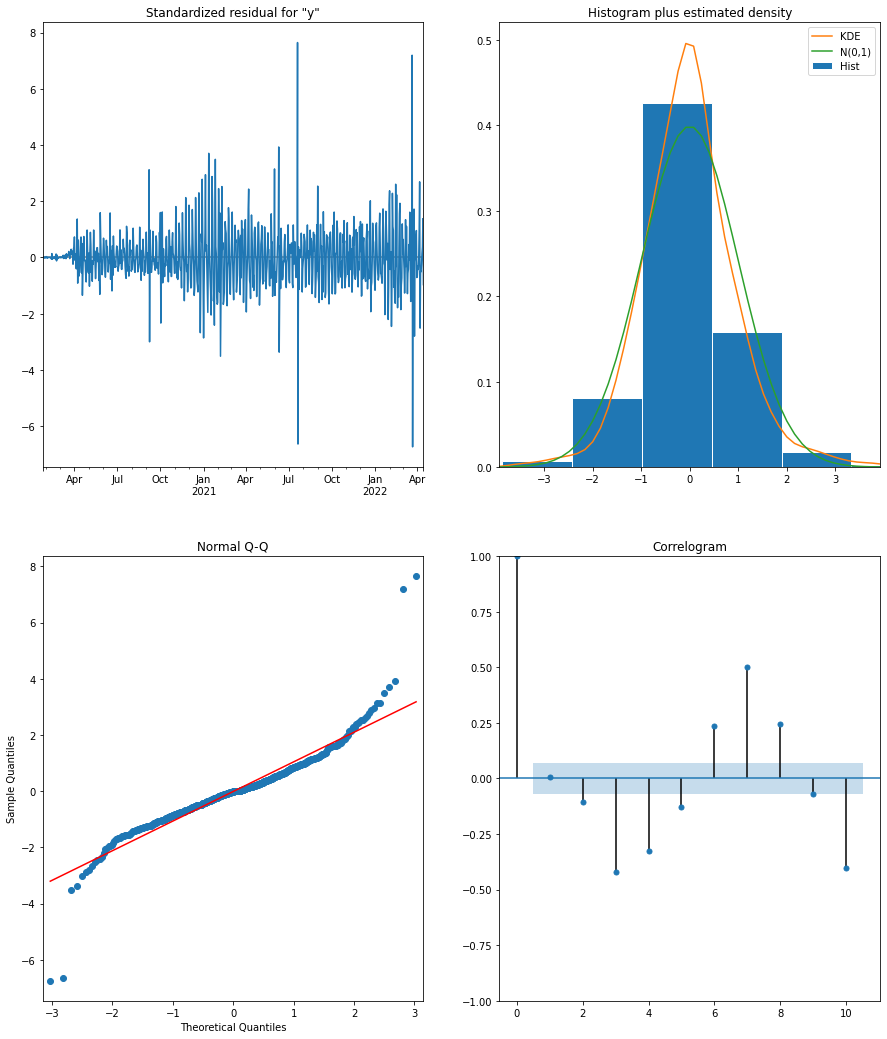

In [55]:
results.plot_diagnostics(figsize=(15,18))
plt.show()

## **Forecast using FB Prophet Model**

Prophet expects the data to have 2 columns.

In [56]:
# Create a new column containing the date info, which in the previous model had been set as the index.
train['ds']=train.index.values

Create a new Prophet object and call the fit() method.

In [57]:
m=Prophet()
m.fit(train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcevi_dpj/csw9717n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcevi_dpj/k1reguaf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86577', 'data', 'file=/tmp/tmpcevi_dpj/csw9717n.json', 'init=/tmp/tmpcevi_dpj/k1reguaf.json', 'output', 'file=/tmp/tmpjtystpg5/prophet_model-20220815213905.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:39:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:39:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


We will use the model to generate predictions for the test set.

We will create the 'future' dataframe using the make_future_dataframe(), then we will call the predict() function.

In make_future_dataframe(), we will pass the 'periods' parameter, which is the number of days we want to make the prediction for.

In [59]:
future=m.make_future_dataframe(periods=test.shape[0])
prophet_prediction=m.predict(future)

Calculate the Mean Absolute Error for our predictions.

In [60]:
prophet_prediction=prophet_prediction.set_index('ds')
prophet_future=prophet_prediction.yhat.loc[prophet_prediction.index >= cutoff_date]
print('Prophet MAE=', mean_absolute_error(prophet_future, test))

Prophet MAE= 703.8372904255484


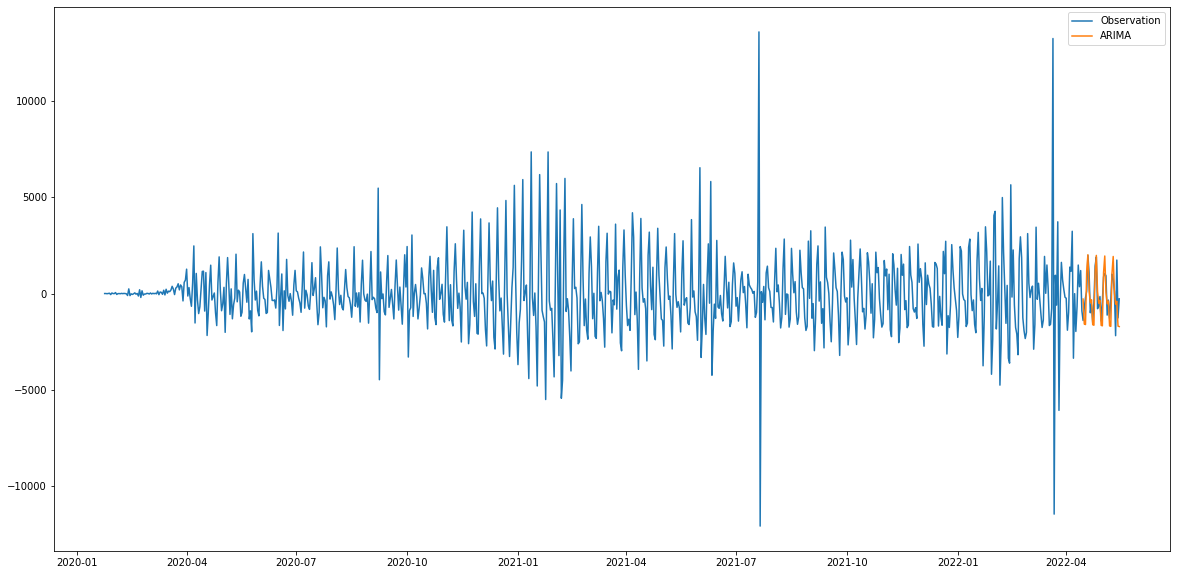

In [61]:
plt.figure(figsize=(20,10))
l1, plt.plot(dataset_diff, label='Observation')
l2, plt.plot(prophet_future, label='Prophet')
plt.legend(handles=[l1,l2])
plt.savefig('prophet predictions', 
            bbox_inches='tight', 
            transparent=False)